# Merck - Molecular Activity

### Goal 
The challenge is to predict the activity value for each molecule/data set combination in the test set. To keep predictions for molecules unique to each data set, a data set identifier has been prepended to each molecule ID (e.g., "ACT1_" or "ACT8_").

### Data
The Training and Test Sets each consist of 15 biological activity data sets in comma separated value (CSV) format.
 Each row of data corresponds to a chemical structure represented by molecular descriptors
es

The training files are of theform

Column 1: Mole  cule ID
Column 2: Activity. Note that these are raw activity values and different data sets can have activity measured in differen  t units.
Column 3-end: Molecular descriptors  /features
The test files are in the same format with Column 2 removed.

Molecule IDs and descriptor names are global to all data sets. Thus some molecules will appear in multiple data sets, as will some " or "ACT8_").

In [107]:
#import
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate,cross_val_score, KFold
import optuna

In [108]:
data =pd.read_csv("data/ACT1_clean.csv")

In [109]:
data.set_index("MOLECULE",inplace=True)

In [110]:
X = data.drop(["Act"],axis=1)
y =data["Act"]

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [77]:
scaler = StandardScaler().fit(X_train.values)
X_train = scaler.transform(X_train.values)
X_test = scaler.transform(X_test.values)

In [92]:
model = xgb.XGBRegressor(objective='reg:squarederror',  n_estimators=1000, learning_rate=0.1, max_depth=8, subsample=0.8,
    colsample_bytree=0.6, reg_alpha=1, reg_lambda=3, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'}

cv_results = cross_validate(model, X_train,y_train, cv=cv,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True )

train_rmse_mean = -cv_results['train_rmse'].mean()
train_rmse_std = cv_results['train_rmse'].std()
train_r2_mean = cv_results['train_r2'].mean()
train_r2_std = cv_results['train_r2'].std()
test_rmse_mean = -cv_results['test_rmse'].mean()
test_rmse_std = cv_results['test_rmse'].std()
test_r2_mean = cv_results['test_r2'].mean()
test_r2_std = cv_results['test_r2'].std()

print("Cross-Validation Performance:")
print(f"Training RMSE: {train_rmse_mean:.4f} (±{train_rmse_std:.4f})")
print(f"Training R²: {train_r2_mean:.4f} (±{train_r2_std:.4f})")
print(f"Validation RMSE: {test_rmse_mean:.4f} (±{test_rmse_std:.4f})")
print(f"Validation R²: {test_r2_mean:.4f} (±{test_r2_std:.4f})\n")

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("Final Test Performance:")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")

Cross-Validation Performance:
Training RMSE: 0.0708 (±0.0014)
Training R²: 0.9879 (±0.0004)
Validation RMSE: 0.3972 (±0.0084)
Validation R²: 0.6199 (±0.0223)

Final Test Performance:
RMSE: 0.3981
R²: 0.6325


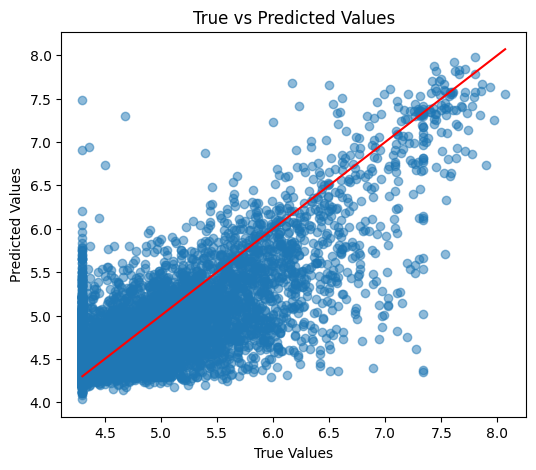

In [93]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [112]:
# 1. Ridge Regression (linear baseline)
ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RidgeCV(alphas=np.logspace(-3, 3, 7)))])

# 2. Support Vector Regressor (nonlinear smooth learner)
svr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR(kernel="rbf", C=10, gamma="scale"))])

# 3. XGBoost (nonlinear ensemble learner)
xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.02,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.6,
    reg_alpha=1,
    reg_lambda=3,
    random_state=42,
    n_jobs=-1)

In [113]:
stack = StackingRegressor(
    estimators=[
        ("ridge", ridge),
        ("svr", svr),
        ("xgb", xgb)
    ],
    final_estimator=RidgeCV(alphas=np.logspace(-3, 3, 7)),  # Meta-learner
    passthrough=False,  # Set True to also feed original features to final estimator
    n_jobs=-1)

In [ ]:
stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# ===============================
# Cross-validation (optional)
# ===============================
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stack, X, y, cv=cv, scoring="r2", n_jobs=-1)

print(f"Mean CV R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


#### Hyperparameter Optimization

In [94]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1500, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 15, step=1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step=0.01),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0, step=0.05),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0, step=0.05),
        "gamma": trial.suggest_float("gamma", 0, 5, step=0.1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10, step=1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5, step=0.1),   # L1 regularization
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5, step=0.1), # L2 regularization
    }

    model = xgb.XGBRegressor(
        **param,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="r2")
    return scores.mean()


In [95]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print(f"  Best R² (CV): {study.best_trial.value:.4f}")
print(f"  Params: {study.best_trial.params}")

best_params = study.best_trial.params
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)

print(f"\nTest R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

[I 2025-10-22 23:16:58,688] A new study created in memory with name: no-name-46c1dd43-5d5d-4941-944b-a81a1cab7fc4
[I 2025-10-22 23:17:04,768] Trial 0 finished with value: 0.5806867822928815 and parameters: {'n_estimators': 1400, 'max_depth': 10, 'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.6000000000000001, 'gamma': 0.9, 'min_child_weight': 7, 'reg_alpha': 3.8000000000000003, 'reg_lambda': 2.6}. Best is trial 0 with value: 0.5806867822928815.
[I 2025-10-22 23:17:07,607] Trial 1 finished with value: 0.5463903911408906 and parameters: {'n_estimators': 800, 'max_depth': 8, 'learning_rate': 0.28, 'subsample': 0.9, 'colsample_bytree': 0.35, 'gamma': 1.3, 'min_child_weight': 4, 'reg_alpha': 3.0, 'reg_lambda': 5.0}. Best is trial 0 with value: 0.5806867822928815.
[I 2025-10-22 23:17:14,177] Trial 2 finished with value: 0.5941361114187851 and parameters: {'n_estimators': 1200, 'max_depth': 14, 'learning_rate': 0.02, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.90000

Best trial:
  Best R² (CV): 0.6328
  Params: {'n_estimators': 900, 'max_depth': 7, 'learning_rate': 0.05, 'subsample': 0.75, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.0, 'min_child_weight': 10, 'reg_alpha': 1.4000000000000001, 'reg_lambda': 0.9}

Test R²: 0.6412
Test MSE: 0.1547


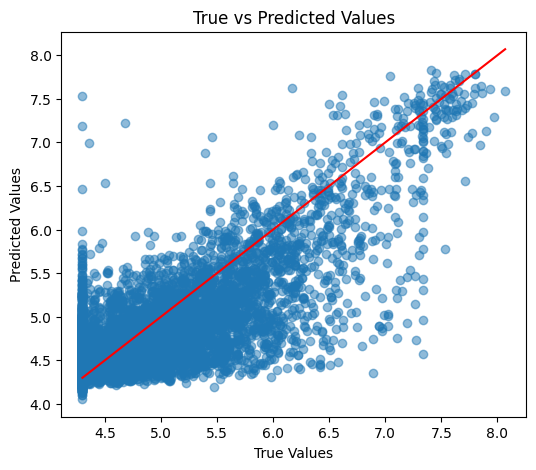

In [96]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

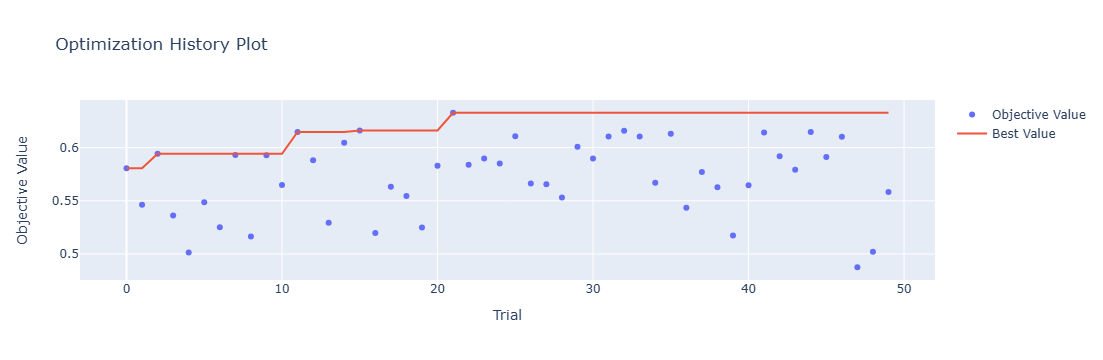

In [97]:
optuna.visualization.plot_optimization_history(study).show()

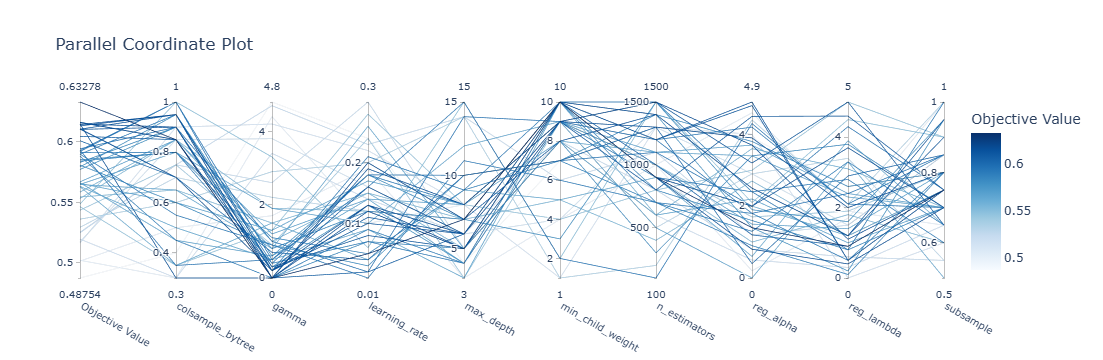

In [98]:
optuna.visualization.plot_parallel_coordinate(study).show()

#### SHAP

In [63]:
import shap

In [64]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)

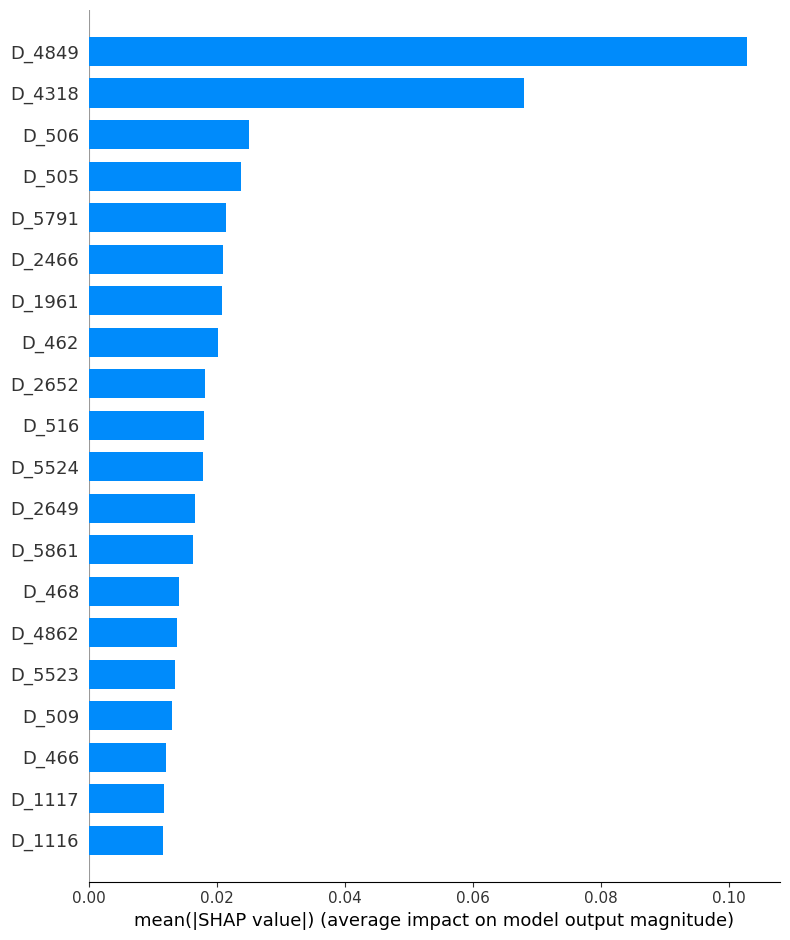

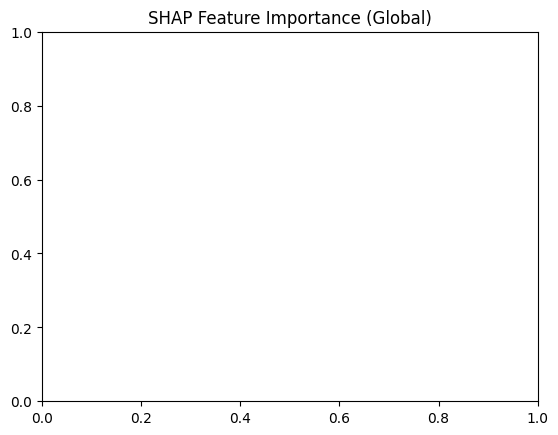

In [65]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, plot_type="bar")
plt.title("SHAP Feature Importance (Global)")
plt.show()

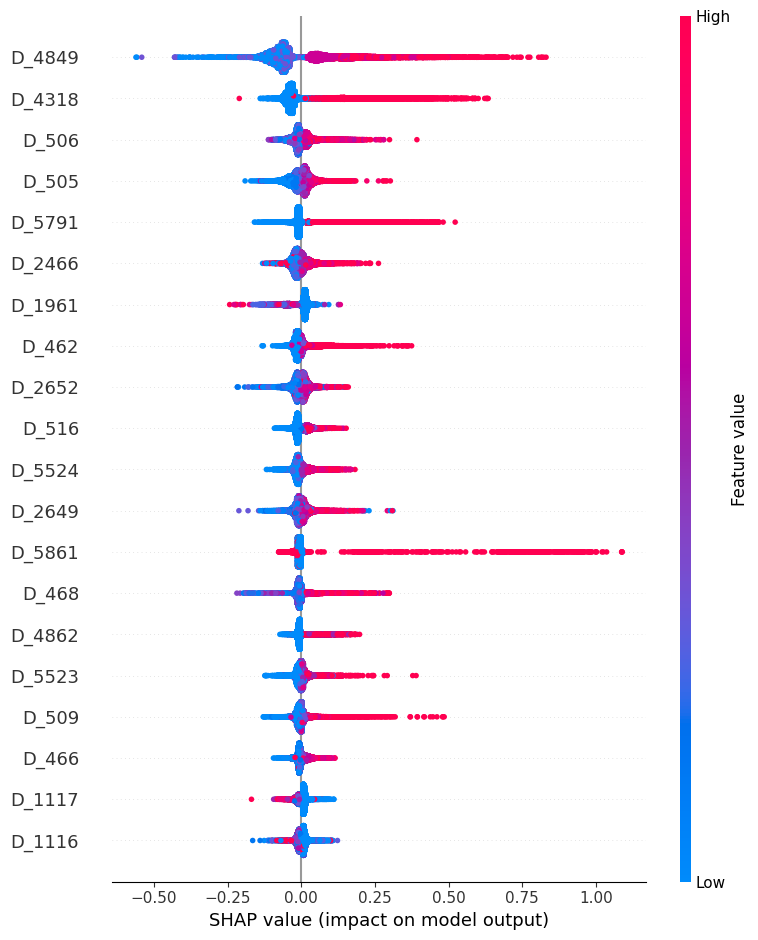

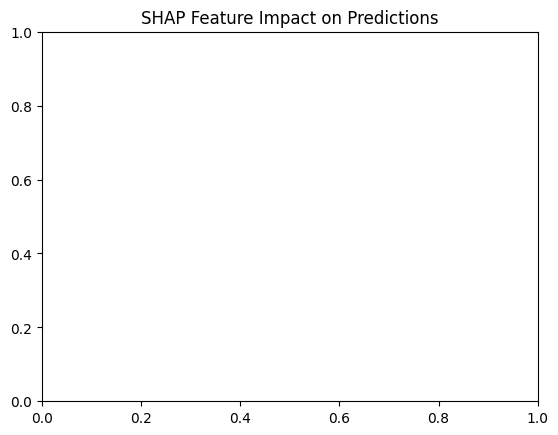

In [66]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train)
plt.title("SHAP Feature Impact on Predictions")
plt.show()